# CPSC4300 - TEAM 2  
### Jeffrey Wang  
I've trained a transformer model to classify tweets as 0:hate, 1:offensive, or 2:neither.  
I drew inspiration from several papers:  
[Automated Hate Speech Detection and the Problem of Offensive Language](https://arxiv.org/abs/1703.04009) is a paper from 2017 by Davidson et al. I use reproduce their paper with a change in model. They use a logistic regression model with L2 regularization. I use Google's [Electra](https://arxiv.org/abs/2003.10555) transformer model taken from [Huggingface](https://huggingface.co/models) using [simpletransformers](https://github.com/ThilinaRajapakse/simpletransformers) Github repo. 
And I ran inference on a random split of Trump and Obama tweets for entertainment value.
Finally I provide a UI so users can enter a twitter username and run inference on max 10 tweets from given username.


**Make sure to go to Runtime > Change Runtime Type > and check for GPU**

In [1]:
# Set Up THIS WILL TAKE A WHILE!
!pip install tokenizers==0.9.3
!pip install gdown
!pip install simpletransformers
!pip install kaggle
!git clone https://github.com/NVIDIA/apex
%cd apex
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

     |████████████████████████████████| 2.9MB 6.9MB/s 
     |████████████████████████████████| 225kB 6.7MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 1.4MB 31.7MB/s 
     |████████████████████████████████| 317kB 43.7MB/s 
     |████████████████████████████████| 1.8MB 25.0MB/s 
     |████████████████████████████████| 7.4MB 25.0MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
     |████████████████████████████████| 890kB 41.1MB/s 
     |████████████████████████████████| 163kB 53.1MB/s 
     |████████████████████████████████| 102kB 13.0MB/s 
     |████████████████████████████████| 133kB 37.8MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 4.5MB 47.8MB/s 
     |████████████████████████████████| 112kB 55.4MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
     |████████████████████████████████| 122kB 48.4MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp3

Cloning into 'apex'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 7865 (delta 7), reused 10 (delta 0), pack-reused 7835
Receiving objects: 100% (7865/7865), 13.99 MiB | 23.21 MiB/s, done.
Resolving deltas: 100% (5356/5356), done.
/content/apex
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-ddltg2v4
Created temporary directory: /tmp/pip-req-tracker-tlso5413
Created requirements tracker '/tmp/pip-req-tracker-tlso5413'
Created temporary directory: /tmp/pip-install-kma67uoe
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-oc7q7g7o
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-tlso5413'
    Run

In [2]:
%cd ..

/content


In [3]:
# all imports
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import logging
import sklearn
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from pprint import pprint
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import requests
import json
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [4]:
# Download trained model, I'm hosting from my gdrive
!gdown https://drive.google.com/uc?id=157lcs2PYCtmxj3ZRLLk0Nm3z_xXhR2lB
!unzip final4300.zip

Downloading...
From: https://drive.google.com/uc?id=157lcs2PYCtmxj3ZRLLk0Nm3z_xXhR2lB
To: /content/final4300.zip
1.10GB [00:04, 237MB/s]
Archive:  final4300.zip
   creating: checkpoint-15490-epoch-5/
  inflating: checkpoint-15490-epoch-5/training_args.bin  
  inflating: checkpoint-15490-epoch-5/scheduler.pt  
  inflating: checkpoint-15490-epoch-5/optimizer.pt  
  inflating: checkpoint-15490-epoch-5/model_args.json  
  inflating: checkpoint-15490-epoch-5/pytorch_model.bin  
  inflating: checkpoint-15490-epoch-5/tokenizer_config.json  
  inflating: checkpoint-15490-epoch-5/config.json  
  inflating: checkpoint-15490-epoch-5/vocab.txt  
  inflating: checkpoint-15490-epoch-5/special_tokens_map.json  


In [5]:
# Logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.CRITICAL) #reduce output by setting logging to critical

# Discard everything expect tweet and class labels. According to paper, 0 is hate, 1 is offensive, 2 is neither 
df = pd.read_csv("https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv")
df = df[["tweet", "class"]]
# I trained final model on entire dataset as in paper so I could compare results
# Train test split was used to find best models
#train, test = train_test_split(df, test_size=0.1)

# Set training arguments
train_args = {'num_train_epochs' : 5,
              'overwrite_output_dir' : True,
              'reprocess_input_data': True
              }
# Create a ClassificationModel, decided to go with Google's Electra
#model = ClassificationModel('electra', 'google/electra-base-discriminator', num_labels=3, args=train_args)
# Here I'm reading in from my gdrive so I only have to train once
model = ClassificationModel("electra", "/content/checkpoint-15490-epoch-5/", num_labels=3, args=train_args)

# Train the model
#model.train_model(df)

In [6]:
# Save the checkpoint
#from google.colab import drive
#drive.mount("/content/drive")

# Evaluate

In [7]:
# Predict
df_test = df["tweet"].to_numpy()
predictions, _ = model.predict(df_test)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [8]:
# Assigned value of 0 to hate/offensive comments and 1 to neither comments so I could take f1 score
df_pred = pd.DataFrame(predictions)
df_pred[0] = df_pred[0].apply(lambda x : int(x == 2))
df_ans = df["class"].apply(lambda x : int(x == 2))

In [9]:
# Evaluate
result, model_outputs, wrong_predictions = model.eval_model(df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:966: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.8345808530035352, 'eval_loss': 0.22111913489416515}


In [10]:
# Append f1 and accuracy scores to results
result["f1"] = f1_score(df_ans, df_pred)
result["acc"] = accuracy_score(df_ans, df_pred)

In [11]:
# See how much was miscategorized and F1 score
print("F1 score of model: {}".format(result["f1"]))
print("Accuracy score of model: {}".format(result["acc"]))
wrong = [{i.text_a : i.label} for i in wrong_predictions]
print("Number of incorrect predictions: {}/{}".format(len(wrong), len(df)))
# Decided not to show the comments because they are inflammatory, but you can uncomment if you want to see

#pprint(wrong)

F1 score of model: 0.9497152550587665
Accuracy score of model: 0.9832546503651697
Number of incorrect predictions: 1456/24783


In [12]:
# Run this again to get unprocessed results
df_test = df["tweet"].to_numpy()
predictions, _ = model.predict(df_test)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


# Confusion Matrix
You can find the original paper's matrix [here](https://arxiv.org/abs/1703.04009). It's figure 1 in results section

Text(69.0, 0.5, 'Predicted Categories')

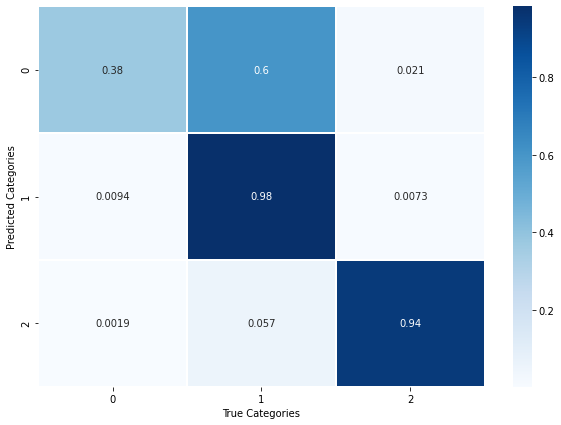

In [13]:
# Plot matrix as in paper
# Calculate what was mislabeled
df_pred_raw = pd.DataFrame(predictions)
target = df["class"].astype('category')
CM = confusion_matrix(target, df_pred_raw[0], labels=target.cat.categories, normalize="true")

df_matrix = pd.DataFrame(CM)
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_matrix, annot=True, linewidths=.5, cmap="Blues")
ax.set_xlabel("True Categories")
ax.set_ylabel("Predicted Categories")

# Predict  
Just for fun, run model through Trump and Obama tweets

In [14]:
# Please do not abuse my key, thanks
kaggle_key = { "username": "jaiwang",
              "key":"1871196faeeb11b3d8971cb002687266" 
              }

In [15]:
with open('kaggle.json', 'w') as fp:
    json.dump(kaggle_key, fp)

In [16]:
# Move key to right place
!kaggle
!mv kaggle.json ~/.kaggle/

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [17]:
# Download datasets from kaggle (Trump and Obama tweets dataset)
!kaggle datasets download -d datacrux/barack-obama-twitterdata-from-20122019
!kaggle datasets download -d austinreese/trump-tweets
!unzip barack-obama-twitterdata-from-20122019.zip
!unzip trump-tweets.zip

  0% 0.00/452k [00:00<?, ?B/s]
100% 452k/452k [00:00<00:00, 73.7MB/s]
  0% 0.00/6.88M [00:00<?, ?B/s]
100% 6.88M/6.88M [00:00<00:00, 113MB/s]
Archive:  barack-obama-twitterdata-from-20122019.zip
  inflating: Tweets-BarackObama.csv  
Archive:  trump-tweets.zip
  inflating: realdonaldtrump.csv     
  inflating: trumptweets.csv         


# Inference
Read in data and randomly pick n tweets
Run inference
Obtain ratios and pick 3 random tweets from each to show


In [18]:
# Read in data
df_trump = pd.read_csv("realdonaldtrump.csv")
df_obama = pd.read_csv("Tweets-BarackObama.csv")
# Discard everything except text
df_trump = df_trump["content"]
df_obama = df_obama["Tweet-text"]

In [19]:
# Returns a df of predictions and corresponding tweets from x random tweets taken from kaggle datasets
def get_sample(x=1000):
  # Process data
  df_trump_sample = df_trump.sample(x).to_numpy() 
  df_obama_sample = df_obama.sample(x).to_numpy()
  # Run inference
  tpred, _= model.predict(df_trump_sample)
  opred, _= model.predict(df_obama_sample)
  # Read in results
  trump_stats = pd.DataFrame([tpred, df_trump_sample]).T
  obama_stats = pd.DataFrame([opred, df_obama_sample]).T

  return trump_stats, obama_stats

In [20]:
# Change n for different size, or obtain a different random sample by rerunning
n = 1000
trump_stats, obama_stats = get_sample(n)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [21]:
# Key 
key = {
    0 : "HATE",
    1 : "OFFENSIVE",
    2 : "NEITHER"
}

In [22]:
# Select random tweets to look at for fun
def show_random():
  r1 = random.randint(0, n)
  r2 = random.randint(0, n)
  r3 = random.randint(0, n)

  print("TRUMP")
  print(key[trump_stats.iloc[r1][0]], trump_stats.iloc[r1][1])
  print(key[trump_stats.iloc[r2][0]], trump_stats.iloc[r2][1])
  print(key[trump_stats.iloc[r3][0]], trump_stats.iloc[r3][1])
  print("-----------------------------------------------------")
  print("OBAMA")
  print(key[obama_stats.iloc[r1][0]], obama_stats.iloc[r1][1])
  print(key[obama_stats.iloc[r2][0]], obama_stats.iloc[r2][1])
  print(key[obama_stats.iloc[r3][0]], obama_stats.iloc[r3][1])

#### Disclaimer: These results are for entertainment purposes only!

In [43]:
# Trump Totals
print("TRUMP")
stats = trump_stats[0].value_counts()
for idx, val in stats.items():
  print("{}: {}".format(key[idx], val))

print()
# Obama Totals
print("OBAMA")
stats = obama_stats[0].value_counts()
for idx, val in stats.items():
  print("{}: {}".format(key[idx], val))

TRUMP
NEITHER: 975
OFFENSIVE: 22
HATE: 3

OBAMA
NEITHER: 991
OFFENSIVE: 8
HATE: 1


In [23]:
# run again to see more random predictions
interact_manual(show_random)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

<function __main__.show_random>

# Custom Tweet Analysis
Pull from any twitter username and run inference!

In [25]:
# Please don't abuse my bearer_token, thank you
# Use twitter API to obtain recent tweets, max=10
def get_tweets(username="lexfridman"):
    bearer_token = "AAAAAAAAAAAAAAAAAAAAAIF9KAEAAAAA6F6GFsIIxHE%2Fo%2BevV5M4ElB2HKw%3D1nLFrbDKX5pbUPc0CxAqcgn9YtMLqsffkI0uXGoVNYzH34yfI5"
    url = "https://api.twitter.com/2/tweets/search/recent?query=from:{}".format(username)
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    response = requests.request("GET", url, headers=headers)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return [i["text"] for i in response.json()["data"]]

In [26]:
# Process, run Inference and print the results
def display_custom_tweets(username="taylorswift13"):
  tweets = get_tweets(username)
  custom_preds, _ = model.predict(tweets)
  for i in range(len(tweets)):
    print(key[custom_preds[i]], tweets[i])

In [27]:
interact_manual(display_custom_tweets, username="lexfridman")

interactive(children=(Text(value='lexfridman', description='username'), Button(description='Run Interact', sty…

<function __main__.display_custom_tweets>